In [5]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


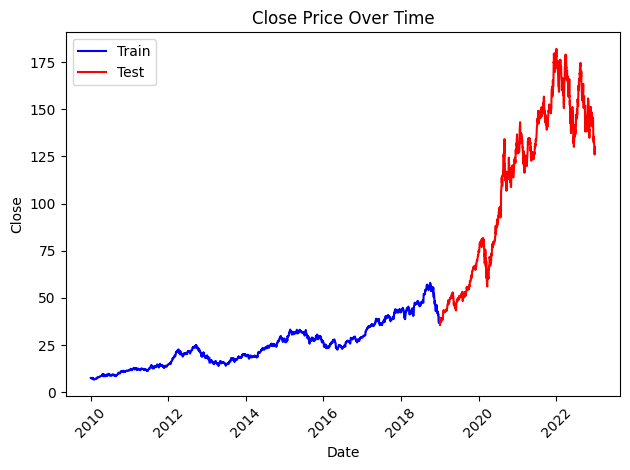

In [6]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
data = Data('AAPL',start_date,end_date,2019)
data.data_preprocess()

Running ring
GENERATION 0 START
Generation 0: Best fitness = 386.32189726763306 Average Fitness = 206.99753406396917
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 422.7833339914272 Average Fitness = 239.23897345366703
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 617.3408803824517 Average Fitness = 260.2222861733824
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 617.3408803824517 Average Fitness = 282.5373449162633
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 645.9239884688299 Average Fitness = 304.6874124319264
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 645.9239884688299 Average Fitness = 320.6683788431047
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 672.6706347848702 Average Fitness = 350.6506030205197
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 672.6706347848702 Average Fitness = 372.09663870262796
GENERATION 7 END
GENERATION 8 START
Generation 8

ValueError: x and y must have same first dimension, but have shapes (100,) and (75,)

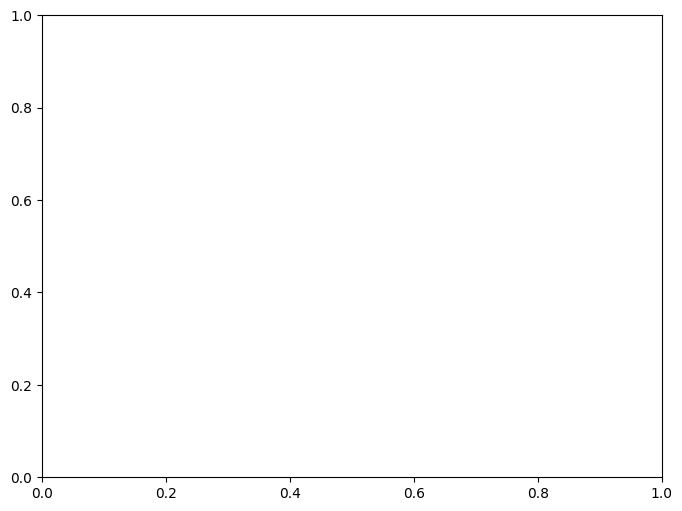

In [8]:
# ring
values = []
migration_rates = [0, 0.5 , 0.8]
num_runs = 10
convergence_values = []
for i in migration_rates:
    values = []
    for _ in range(num_runs):
        ga = IslandGGA(data=data.train_data,num_islands=8,m_iter= 10,num_iter=75,n_migrants_rate=i,pSize=200,r_cross=0.4,r_mut=0.1,strategies=data.strategies,evolve_strategy="ring")
        ga.evolve()
        values.append(ga.convergence_values)
    convergence_values.append(np.mean(values, axis=0))  # Average convergence values across runs

# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(migration_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Migration rate = ' + str(migration_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different migration rates')
plt.legend()
plt.show()

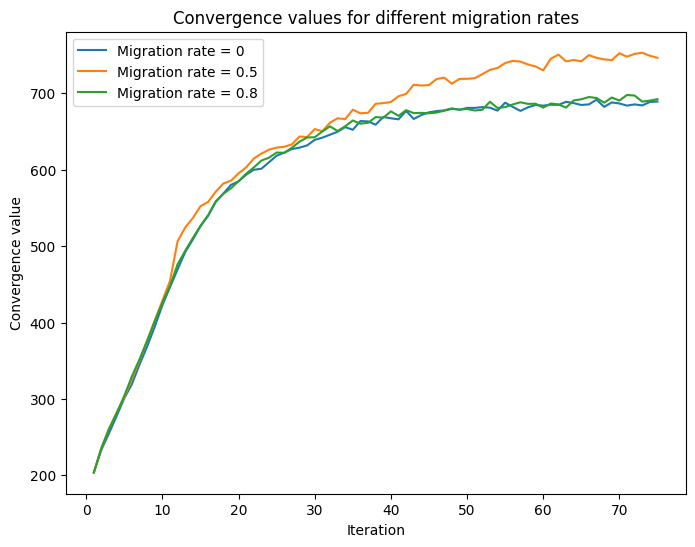

In [9]:
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(migration_rates)):
    plt.plot(np.arange(1, 76), convergence_values[i], label='Migration rate = ' + str(migration_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different migration rates')
plt.legend()
plt.show()

Running multikuti
GENERATION 0 START
Generation 0: Best fitness = 342.9532515099631 Average Fitness = 202.90390883515693
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 367.5428768134263 Average Fitness = 241.73498721462983
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 368.48934890164344 Average Fitness = 260.9583214343313
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 441.4598493564405 Average Fitness = 281.6788459264817
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 619.8013537525567 Average Fitness = 303.7238677013156
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 621.2719531667029 Average Fitness = 314.0422675273562
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 621.2719531667029 Average Fitness = 336.88235045779294
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 630.3391055740852 Average Fitness = 362.1530434841829
GENERATION 7 END
GENERATION 8 START
Generat

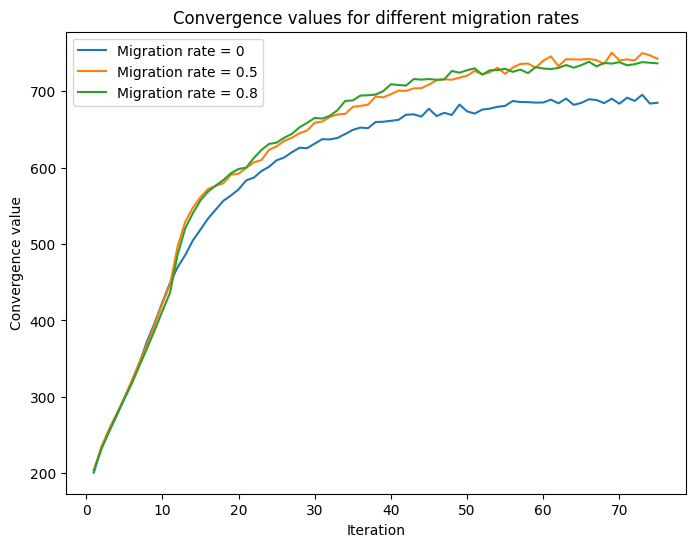

In [10]:
# multikuti
values = []
migration_rates = [0, 0.5 , 0.8]
num_runs = 10
convergence_values = []
for i in migration_rates:
    values = []
    for _ in range(num_runs):
        ga = IslandGGA(data=data.train_data,num_islands=8,m_iter= 10,num_iter=75,n_migrants_rate=i,pSize=200,r_cross=0.4,r_mut=0.1,strategies=data.strategies,evolve_strategy="multikuti")
        ga.evolve()
        values.append(ga.convergence_values)
    convergence_values.append(np.mean(values, axis=0))  # Average convergence values across runs

# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(migration_rates)):
    plt.plot(np.arange(1, 76), convergence_values[i], label='Migration rate = ' + str(migration_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different migration rates')
plt.legend()

In [13]:
from scipy import stats

# Compare the convergence metrics of the two algorithms
t_statistic, p_value = stats.ttest_ind(convergence_values[0], convergence_values[2])

# Print the results
if p_value < 0.05:
    print("The difference in convergence is statistically significant.")
else:
    print("The difference in convergence is not statistically significant.")
print(p_value)


The difference in convergence is not statistically significant.
0.13504377582543448
